# UFC Chicago Twitter Stream Topic Modeling

This notebook uses Latent Dirichlet Allocation (LDA) to perform topic modeling on a stream of tweets collected during the UFC Chicago event held on July 25th 2015.  The data was collected using Python, Tweepy, and MySQL as outlined [here](http://miningthedetails.com/blog/python/TwitterStreamsPythonMySQL/). The tweets were parsed using a version of [Christopher Pott's happy fun tokenizer](http://sentiment.christopherpotts.net/tokenizing.html) provided by the [World Well Being Project at UPenn](http://www.wwbp.org/data.html).   


In [7]:
import pandas as pd
from pandas.tseries.resample import TimeGrouper
from pandas.tseries.offsets import DateOffset
import numpy as np
from langdetect import detect, lang_detect_exception
from nltk import FreqDist,WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models
import pyLDAvis.gensim
import csv
import pickle
import re
import warnings
import seaborn as sns

# ignore user warning for seaborn
warnings.simplefilter('ignore', UserWarning )
warnings.simplefilter('ignore', DeprecationWarning)

# list of fights from the UFC Chicago main card
fighters = {'tjdillashaw':['tj', 'dillashaw'],
            'renanbarao':['renan','barao','baroa'],
            'mieshatate':['meisha','miesha','tate'],
            'jessicaeye':['jessica'],# eye is a common word, don't include
            'edsonbarboza':['edson','barboza'],
            'paulfelder':['paul','felder'],
            'joelauzon':['lauzon'], # can't include joe because of announcers
            'takanorigomi':['takanori','gomi'],
            'gianvillante':['gian', 'villante', 'vilante'],
            'tomlawlor':['tom','lawlor'],
            'jimmiller':['jim', 'miller'],
            'dannycastillo':['danny', 'castillo'],
            'kennyrobertson':['kenny','robertson'],
            'bensaunders':['ben', 'saunders'],
            'eddiewineland':['eddie', 'wineland'],
            'bryancaraway':['bryan', 'caraway'] }





# import tweet dataset
ds = pd.read_csv("data/ufcChicago_tweets.csv", low_memory=False)
print(ds.head())

# import tokenized tweets
fileObject = open('data/parsedTweets','rb')  
# load the object from the file into var b
tweets = pickle.load(fileObject) 


                       created_at        username  \
0  Sat Jul 25 22:25:41 +0000 2015  toddbishop44sp   
1  Sat Jul 25 22:25:41 +0000 2015     MMAWreckage   
2  Sat Jul 25 22:25:42 +0000 2015          216Zac   
3  Sat Jul 25 22:25:43 +0000 2015      ELPILLORDZ   
4  Sat Jul 25 22:25:46 +0000 2015     RobTatumMMA   

                                               tweet coordinates  \
0  #UFCChicago what a lousy fight both fighters s...         NaN   
1  RT @BloodyElbow: Wineland losing to Caraway at...         NaN   
2  RT @NSyarylla: Wineland looks like a different...         NaN   
3  RT @UFCONFOX: Wineland having his best round. ...         NaN   
4  "That was the jaw that was broken." -Joe Rogan...         NaN   

                  userTimeZone           userLocation  retweeted  
0                          NaN  Pelzer South Carolina          0  
1   Pacific Time (US & Canada)                    NaN          0  
2                          NaN                    NaN          0  
3   

Additional pre-processing of the tweets is carried out below.  All retweets and user mentions are identified and stored in separate lists.  A distinct list of tweets is also created which has all mentions and retweets removed. 

In [8]:
mentions = []
retweets = []
distinctTweet = []
import re

#  filter  out retweets and save results in 
#  distinctTweet

#  filter  out mentions
for tw in tweets:
    rt = False
    for t in tw:
        if re.match('@\\w',t):
            mentions.append(t)
        if re.match('rt',t):
            rt = True
    if rt:
        retweets.append(tw)
    else:
        distinctTweet.append(tw)

Stopwords and links are removed from the distinct tweets followed by [lemmatization](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) of the tweets. 

In [9]:

# remove mentions
# remove remaining punctuation


stopwords = stopwords.words('english')
additional_stopwords = ['ufc','http','https', 'ufcchicago', 'ufconfox','ufcfightnight', '...']
for sword in additional_stopwords:
    stopwords.append(sword)


lem = WordNetLemmatizer()
# remove stop words ands stem words
filtered_tweets = []
for tw in distinctTweet:
    # remove stop words
    filtered_tweets.append([lem.lemmatize(w) for w in tw if w.lower() not in stopwords and
                            len(w.lower()) > 2 and
                            not (re.match('@\\w',w)) and
                            not (re.match('#\\w',w)) and
                            not (re.match('htt\\w',w))])



To aid in identification of the fighters, the previously defined <i>fighters</i> dictionary is used to convert the individual first and last name of the fighters into a combined first and last name with no whitespace present.  Some exceptions had to be made with the fighters. For example JoeLauzon only looks for Lauzon, since one of the primary announcers is also named Joe (Rogan). 

In [10]:
# check for fighter names and convert to the full name
for i in range(0, len(filtered_tweets)):
    for k in range(0, len(filtered_tweets[i])):
        for key,value in fighters.items():
            for v in value:            
                filtered_tweets[i][k]=re.sub(r"\b%s\b" % v, key, filtered_tweets[i][k])


Below is commented code for performing LDA with a single core with the gensim package.  However since I had 4 cores at my disposal I used the <i>ldamulticore.LdaMulticore</i> function.  There were 8 fights on the card while I was recording, so I decided I'd look for a slightly higher number of topics, 10.

In [11]:

# # LDA using single core
# dictionary = corpora.Dictionary(filtered_tweets)
# corpus = [dictionary.doc2bow(text) for text in filtered_tweets]

# # model the topics
# ldamodel = models.ldamodel.LdaModel(corpus, num_topics=8, id2word = dictionary, passes=50)



In [12]:
#LDA using 4 cores
dictionary = corpora.Dictionary(filtered_tweets)
corpus = [dictionary.doc2bow(text) for text in filtered_tweets]

ldamodel = models.ldamulticore.LdaMulticore(corpus, num_topics=10, 
                                                   id2word = dictionary, passes=50, workers=3)

The <i>pyLDAvis</i> package is used to plot the results of the topic model.  If you take a look at model topic 8, you'll see that Cole Hamels name present as one of the most used names.  At the time Cole Hamels was still pitching for the Philadelphia Phillies and threw a no-hitter that night in Chicago while the fights were airing.  Was strange seeing this considering the search term used in tweet collection was <i>UFC</i>, but it was a significant event that fight fans seem to react to as well. 

In [13]:

ufc_vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(ufc_vis_data)

# cole hamels threw a no-hitter against Chicago, game ended around 6:40 (4pm start time, 2:38 duration)

The remainder of the notebook calculates the number of tweets per minute and displays them as a function of time using the seaborn package. 

In [14]:
# convert to time series
ds['created_at'] = pd.to_datetime(pd.Series(ds['created_at']))
ds.set_index('created_at', drop=False, inplace=True)
ds.index = ds.index.tz_localize('GMT').tz_convert('EST')
ds.index = ds.index - DateOffset(hours = 12)



In [15]:
start_time = ds.index.min()
end_time   = ds.index.max()


# minute = Minute()
date_bin = pd.date_range(start_time, end_time, freq='T')
tweet_frequency = pd.Series(np.zeros(len(date_bin)), index=date_bin)    
for date_entry in range(1,len(date_bin)):
    temp = temp = ds[ds.index > date_bin[(date_entry-1)]]
    temp = temp[temp.index < date_bin[date_entry]]
    tweet_frequency[date_entry] = len(temp)
tweet_frequency.head()

2015-07-25 05:25:41-05:00      0
2015-07-25 05:26:41-05:00    124
2015-07-25 05:27:41-05:00    133
2015-07-25 05:28:41-05:00    109
2015-07-25 05:29:41-05:00    140
Freq: T, dtype: float64

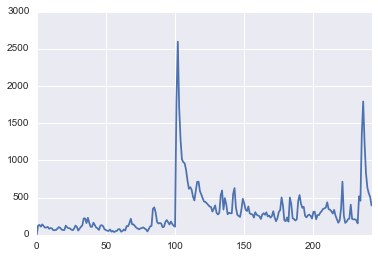

In [16]:
%matplotlib inline

sns.tsplot(data=tweet_frequency)